## ✅ Task 1: Extract insights from data (15%)

### 1.1 Installing and Importing the libraries 

In [2]:
# Standard library imports
import os
import re
import string
import math
import random
import datetime
import json
from collections import Counter, defaultdict

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# NLP and text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from num2words import num2words

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Deep learning - TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical

# Deep learning - PyTorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

c:\Users\laure\Documents\Uni Sachen\TU Berlin\2. Semester\NLP\Projekt\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

### 1.2 Importing and Preparing Text Data for Analysis

In [3]:
# Read the labeled sentences file, splitting each line into sentence and label at the last '@'
with open("Sentences_50Agree.txt", "r", encoding="latin-1") as f:
    lines = [line.strip().rsplit("@", 1) for line in f if "@" in line]

# Create a DataFrame with columns for sentences and their labels; add a column for sentence character length
df = pd.DataFrame(lines, columns=["sentence", "label"])
df["char_length"] = df["sentence"].apply(len)

# Define the order of sentiment labels and assign a color palette for consistent plotting
ordered_labels = ["neutral", "negative", "positive"]
palette = sns.color_palette("Set2")
label_colors = dict(zip(ordered_labels, palette))

# Load the set of English stopwords for later text processing
stop_words = set(stopwords.words('english'))

# Compute statistics for each label: count, mean sentence length, and median sentence length
label_counts = df["label"].value_counts().reindex(ordered_labels, fill_value=0)
mean_lengths = df.groupby("label")["char_length"].mean().reindex(ordered_labels)
median_lengths = df.groupby("label")["char_length"].median().reindex(ordered_labels)

# Define a tokenization function: lowercase, remove stopwords, and keep only alphabetic words
def tokenize(text):
    return [word.lower() for word in text.split() if word.lower() not in stop_words and word.isalpha()]

# Apply tokenization to each sentence and store the result in a new column
df["tokens"] = df["sentence"].apply(tokenize)

# For each label, collect the set of unique words used; also count the number of unique words per label
unique_words_by_label = df.groupby("label")["tokens"].apply(lambda x: set(word for tokens in x for word in tokens))
unique_counts = unique_words_by_label.apply(len).reindex(ordered_labels)

# Create a set of all unique words across all labels
unique_words_all = set().union(*unique_words_by_label)

### 1.3 Visual Summary of Sentiment Labels and Text Characteristics

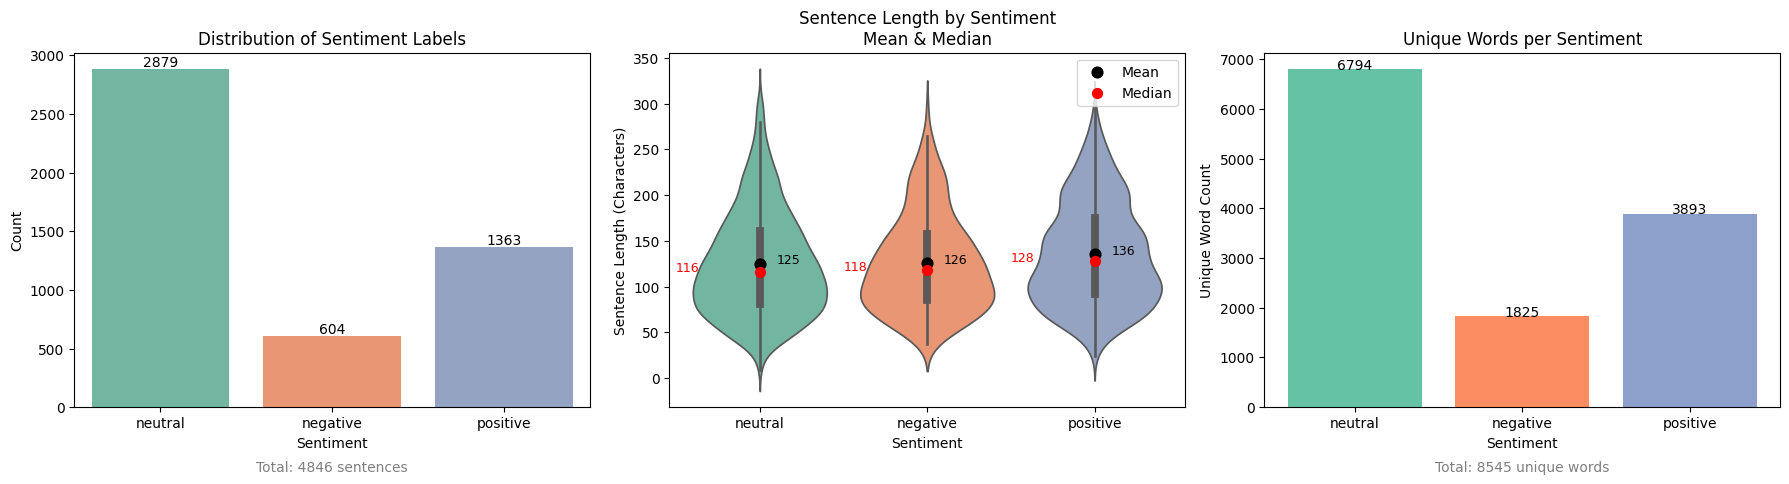

In [4]:
# Create a figure with 3 horizontally arranged subplots for visualizing different text statistics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Sentiment Label Distribution ---
# Show the count of each sentiment label using a color-coded bar plot
sns.countplot(data=df, x="label", order=ordered_labels, hue="label", palette=label_colors, ax=axes[0])
axes[0].set(title="Distribution of Sentiment Labels", xlabel="Sentiment", ylabel="Count")

# Display the count value above each bar for clarity
for i, label in enumerate(ordered_labels):
    count = label_counts[label]
    axes[0].text(i, count + 1, str(count), ha="center", va="bottom", fontsize=10)

# Add a note below the plot indicating the total number of sentences in the dataset
axes[0].annotate(f"Total: {len(df)} sentences", xy=(0.5, -0.18), xycoords='axes fraction',
                 ha='center', fontsize=10, color='gray')

# --- Plot 2: Sentence Length Distribution by Sentiment ---
# Visualize the distribution of sentence lengths for each sentiment using violin plots
sns.violinplot(data=df, x="label", y="char_length", order=ordered_labels, hue="label",
               palette=label_colors, inner="box", ax=axes[1])

# Overlay mean (black) and median (red) sentence lengths for each sentiment
for i, label in enumerate(ordered_labels):
    mean = mean_lengths[label]
    median = median_lengths[label]
    axes[1].scatter(i, mean, color="black", s=60, zorder=10, label="Mean" if i == 0 else "")
    axes[1].text(i + 0.1, mean, f"{mean:.0f}", color="black", fontsize=9)
    axes[1].scatter(i, median, color="red", s=50, zorder=11, label="Median" if i == 0 else "")
    axes[1].text(i - 0.5, median, f"{median:.0f}", color="red", fontsize=9)
axes[1].set(title="Sentence Length by Sentiment\nMean & Median",
            xlabel="Sentiment", ylabel="Sentence Length (Characters)")
axes[1].legend(loc="upper right")

# --- Plot 3: Unique Word Count per Sentiment ---
# Show the number of unique words used in each sentiment category as a bar plot
bars = axes[2].bar(ordered_labels, unique_counts, color=[label_colors[l] for l in ordered_labels])
axes[2].set(title="Unique Words per Sentiment", xlabel="Sentiment", ylabel="Unique Word Count")

# Annotate each bar with its unique word count
for bar, count in zip(bars, unique_counts):
    axes[2].text(bar.get_x() + bar.get_width() / 2, count + 5, str(count), ha='center', fontsize=10)

# Add a note below the plot indicating the total number of unique words across all sentiments
axes[2].annotate(f"Total: {len(unique_words_all)} unique words", xy=(0.5, -0.18),
                 xycoords='axes fraction', ha='center', fontsize=10, color='gray')

# Adjust subplot layout for better spacing and display the figure
plt.tight_layout()
plt.show()

### 1.4 Top-N Word Frequency Overview by Sentiment

In [5]:
def plot_top_words_grid(df, tokenize_fn, top_n=15, title_suffix=""):
    """
    Creates a 2x2 grid visualization of word frequencies across sentiment classes.
    Shows top-N words per class and their relative frequencies across all classes.
    """
    # Set up a 2x2 grid of subplots for visualizing word frequencies
    fig, axes = plt.subplots(2, 2, figsize=(20, 10), gridspec_kw={'height_ratios': [1, 1]})
    axes = axes.flatten()

    class_word_counts = {}      # Dictionary to store word frequency Counter for each class
    all_words_combined = []     # List to collect all words from all classes

    # Compute word frequencies for each sentiment class and plot their top-N words
    for i, label in enumerate(ordered_labels):
        texts = df[df["label"] == label]["sentence"]
        # Tokenize and flatten all words for this class
        words = [word for sentence in texts for word in tokenize_fn(sentence)]
        class_word_counts[label] = Counter(words)
        all_words_combined.extend(words)

        # Plot a bar chart of the top-N most frequent words for this class
        top_words = class_word_counts[label].most_common(top_n)
        if not top_words:
            continue
        words_, freqs_ = zip(*top_words)
        axes[i].bar(words_, freqs_, color=label_colors[label])
        axes[i].set(
            title=f"Top {top_n} Words – {label.capitalize()} {title_suffix}",
            ylabel="Frequency"
        )
        axes[i].tick_params(axis='x', rotation=45)

    # Find the top-N most frequent words across all classes combined
    global_top_words = [word for word, _ in Counter(all_words_combined).most_common(top_n)]

    # Build a matrix of relative frequencies for each top word across all classes
    # Each row: a word; each column: the proportion of that word's occurrences in each class
    data = [
        [
            (class_word_counts[label][word] / sum(class_word_counts[l][word] for l in ordered_labels)
             if sum(class_word_counts[l][word] for l in ordered_labels) > 0 else 0)
            for label in ordered_labels
        ]
        for word in global_top_words
    ]

    freq_df = pd.DataFrame(data, index=global_top_words, columns=ordered_labels)

    # Plot a stacked horizontal bar chart to compare class-wise proportions for each top word
    freq_df.plot(
        kind='barh', stacked=True,
        color=[label_colors[label] for label in ordered_labels],
        width=0.9, ax=axes[3]
    )
    axes[3].set(
        title=f"Class-wise Relative Frequency of Top {top_n} Words {title_suffix}",
        xlabel="Proportion", ylabel="Word"
    )
    axes[3].legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[3].invert_yaxis()  # Show most frequent words at the top

    plt.tight_layout()
    plt.show()

#### 1.4.1 Top-N Word Frequency Overview by Sentiment **Without Pre-Processing**

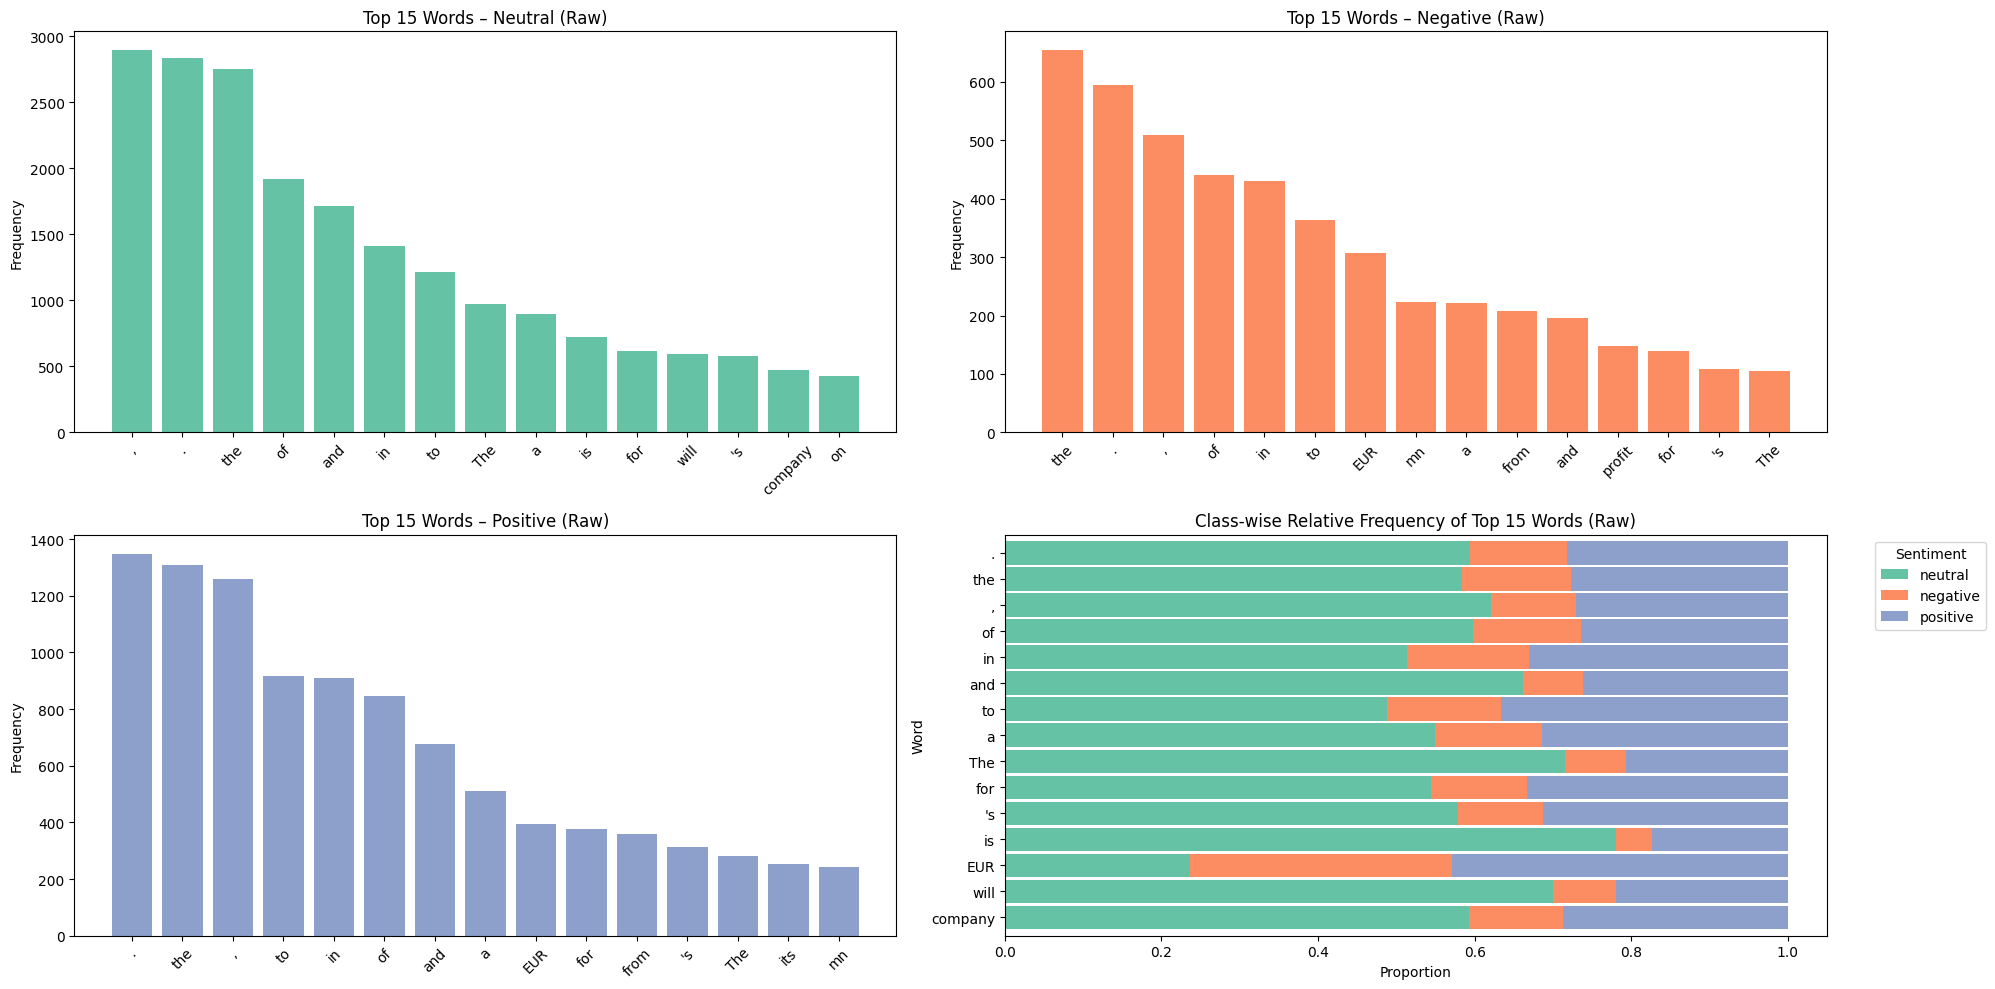

In [6]:
plot_top_words_grid(df, tokenize_fn=lambda text: text.split(), title_suffix="(Raw)")

#### 1.4.2 Top-N Word Frequency Overview by Sentiment **With Pre-Processing** (lowercase, without punctuation, without stopwords)

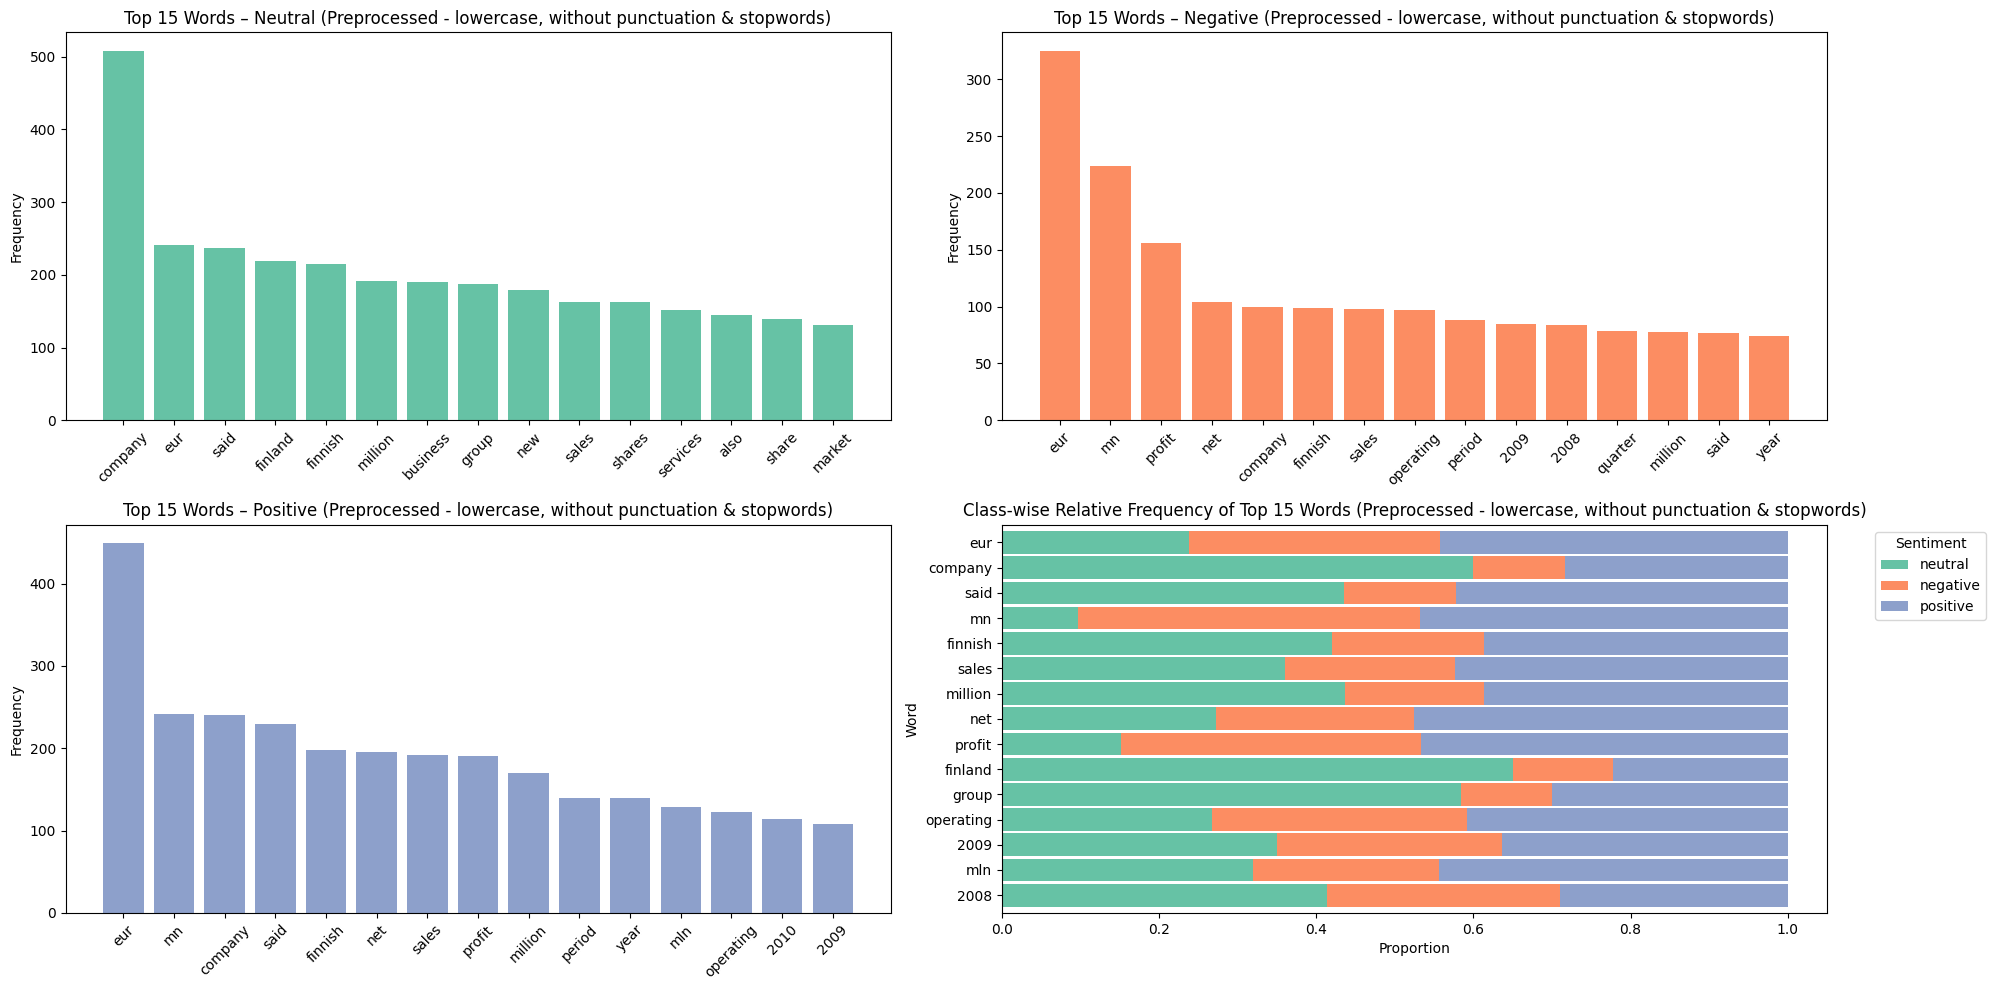

In [7]:
def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove all punctuation characters
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Split text into tokens (words)
    tokens = text.split()
    # Remove stopwords from the token list
    return [word for word in tokens if word not in stop_words]

# Plot the top-N word frequencies using preprocessed tokens (lowercase, no punctuation, no stopwords)
plot_top_words_grid(df, tokenize_fn=preprocess, title_suffix="(Preprocessed - lowercase, without punctuation & stopwords)")

### 1.5 Word Clouds per Sentiment Class

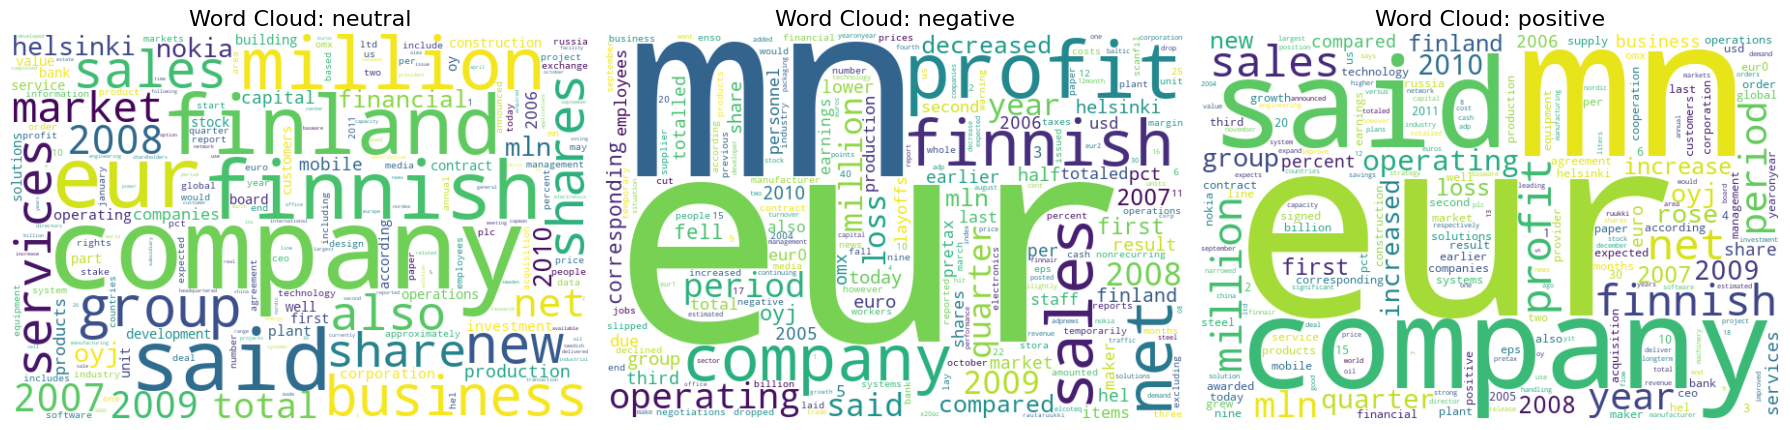

In [8]:
# Set up a subplot for each sentiment class to display their respective word clouds
fig, axes = plt.subplots(1, len(ordered_labels), figsize=(18, 6))

# For each sentiment class, generate and display a word cloud based on preprocessed word frequencies
for ax, label in zip(axes, ordered_labels):
    # Preprocess and tokenize all sentences belonging to the current sentiment class
    tokenized_sentences = df[df["label"] == label]["sentence"].apply(preprocess)
    # Flatten the list of token lists into a single list of words
    all_words = [word for tokens in tokenized_sentences for word in tokens]
    # Count the frequency of each word
    word_counts = Counter(all_words)
    # Generate a word cloud from the word frequencies
    wordcloud = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(word_counts)
    # Display the word cloud on the corresponding subplot axis
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"Word Cloud: {label}", fontsize=16)

plt.tight_layout()
plt.show()

### 1.6 Word Frequency Analysis by Sentiment (Heatmap & Colored Word Cloud)

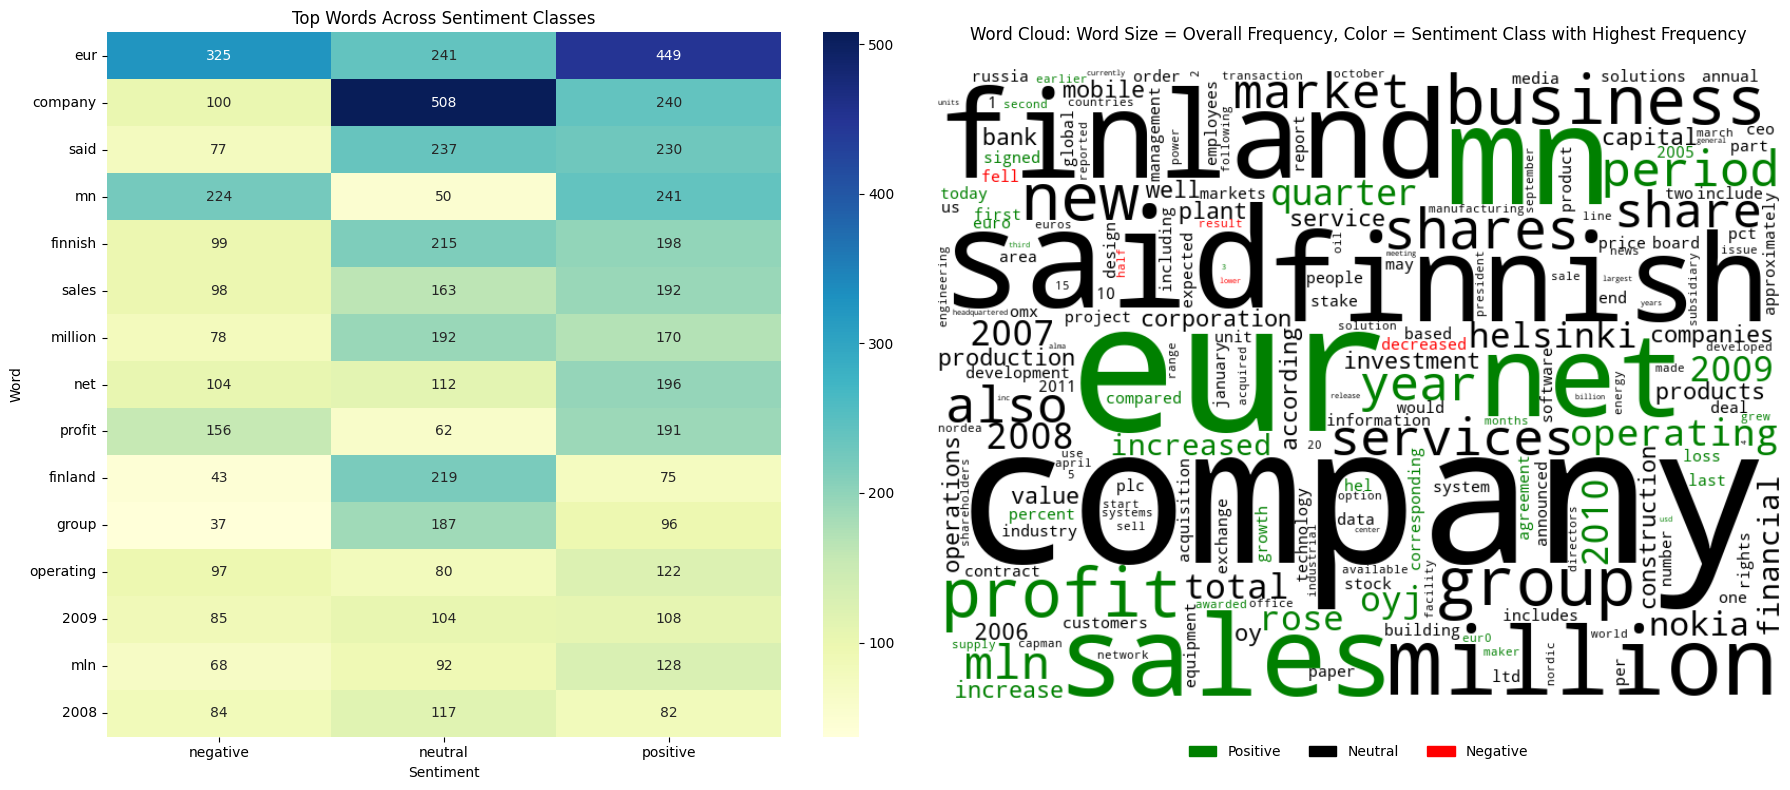

In [9]:
# Retrieve sorted sentiment labels and assign a distinct color to each class for visualization
labels = sorted(df["label"].unique())
label_colors = {'positive': 'green', 'neutral': 'black', 'negative': 'red'}

# Initialize dictionaries to store word counts per class, global word frequencies, and dominant class per word
class_word_counts = {}
word_class_freq = {}
word_to_label = {}
all_words = []

# Compute word frequencies for each sentiment class and track overall word usage
for label in labels:
    # Get all sentences for the current sentiment class
    texts = df[df["label"] == label]["sentence"]
    # Preprocess and tokenize all sentences, flattening into a single list of words
    words = [word for sentence in texts for word in preprocess(sentence)]
    # Count word occurrences for the current class
    counts = Counter(words)
    class_word_counts[label] = counts
    # Add words to the global list for overall frequency analysis
    all_words.extend(words)

    # For each word, if its frequency in this class is the highest seen so far, record it and its class
    for word, count in counts.items():
        if count > word_class_freq.get(word, 0):
            word_class_freq[word] = count
            word_to_label[word] = label

# Identify the top-N most frequent words across all sentiment classes
global_top_words = [word for word, _ in Counter(all_words).most_common(15)]

# Construct a frequency matrix (rows: words, columns: sentiment classes) for the heatmap
freq_matrix = pd.DataFrame({
    label: [class_word_counts[label][word] for word in global_top_words]
    for label in labels
}, index=global_top_words)

# Set up a figure with two subplots: one for the heatmap, one for the colored word cloud
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot the heatmap of word frequencies by sentiment class
sns.heatmap(freq_matrix, annot=True, fmt="d", cmap="YlGnBu", ax=axes[0])
axes[0].set(title="Top Words Across Sentiment Classes", xlabel="Sentiment", ylabel="Word")

# Define a function to assign colors to words in the word cloud based on their dominant sentiment class
def color_func(word, **kwargs):
    return label_colors.get(word_to_label.get(word, 'neutral'), 'black')

# Generate a word cloud where each word is colored by its most frequent sentiment class
wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(word_class_freq)
axes[1].imshow(wordcloud.recolor(color_func=color_func), interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("Word Cloud: Word Size = Overall Frequency, Color = Sentiment Class with Highest Frequency", pad=20)

# Nach dem Zeichnen der Wordclouds:
legend_patches = [
    mpatches.Patch(color='green', label='Positive'),
    mpatches.Patch(color='black', label='Neutral'),
    mpatches.Patch(color='red', label='Negative')
]

plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False)
plt.tight_layout()
plt.show()

## ✅ Task 2: Pre-processing (10%)

In [3]:
def get_preprocessed_text_df(
    lowercase=True,
    replace_currency=True,
    replace_unicode=True,
    remove_possessive=True,
    replace_percent=True,
    standardize_number_abbr=True,
    replace_number_ranges=True,
    remove_hyphens_in_words=True,
    remove_commas_in_numbers=True,
    remove_punctuation=True,
    normalize_whitespace=True,
    remove_period_space=True,
    lemmatize=True,
    stem=True,
    remove_stopwords=True
):

    # Initialize stopwords, lemmatizer, and stemmer
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()

    def get_wordnet_pos(treebank_tag):
        """
        Map POS tag from Penn Treebank to WordNet POS tag for lemmatization.
        """
        if treebank_tag.startswith('J'):
            return nltk.corpus.wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return nltk.corpus.wordnet.VERB
        elif treebank_tag.startswith('N'):
            return nltk.corpus.wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return nltk.corpus.wordnet.ADV
        else:
            return nltk.corpus.wordnet.NOUN  # Default to noun if unknown

    def preprocess(text):
        """
        Apply a series of configurable preprocessing steps to a single text string.
        """
        # Convert to lowercase if specified
        if lowercase:
            text = text.lower()
        # Replace currency symbols with words
        if replace_currency:
            text = text.replace('$', ' dollar ')
            text = text.replace('€', ' euro ')
            text = text.replace('£', ' pound ')
        # Replace common unicode encodings for currency and punctuation
        if replace_unicode:
            text = re.sub(r'\\?x20ac', ' euro ', text)
            text = re.sub(r'\\?x24', ' dollar ', text)
            text = re.sub(r'\\?x00a3', ' pound ', text)
            text = re.sub(r'\\?x2013', ' ', text)   # en dash
            text = re.sub(r'\\?x2019', "'", text)   # right single quote
        # Remove possessive 's
        if remove_possessive:
            text = re.sub(r"\b([a-zA-Z]+)\s*'s\b", r"\1", text)
        # Replace percent signs with the word 'percent'
        if replace_percent:
            text = re.sub(r'(\d+\.?\d*)\s*%', r'\1 percent', text)
        # Standardize number abbreviations (e.g., 5m -> 5 million)
        if standardize_number_abbr:
            text = re.sub(r'(\d+\.?\d*)\s*(mn|m|mln|million|millions)\b', r'\1 million', text)
            text = re.sub(r'(\d+\.?\d*)\s*(bn|b|bln|billion|billions)\b', r'\1 billion', text)
        # Replace number ranges (e.g., 5-10 -> 5 to 10)
        if replace_number_ranges:
            text = re.sub(r'(?<=\d)\s*-\s*(?=\d)', ' to ', text)
            text = re.sub(r'(?<=percent)\s*-\s*(?=\d)', ' to ', text)
            text = re.sub(r'(?<=percent)\s*-\s*(?=percent)', ' to ', text)
        # Remove hyphens within words (e.g., state-of-the-art -> stateoftheart)
        if remove_hyphens_in_words:
            text = re.sub(r'(?<=[a-zA-Z])-(?=[a-zA-Z])', '', text)
        # Remove commas within numbers (e.g., 1,000 -> 1000)
        if remove_commas_in_numbers:
            text = re.sub(r'(?<=\d),(?=\d)', '', text)
        # Remove all punctuation except periods (for sentence boundaries)
        if remove_punctuation:
            allowed = string.ascii_lowercase + string.digits + "."
            text = re.sub(f"[^{re.escape(allowed)}]", " ", text)
        # Normalize whitespace (collapse multiple spaces, trim ends)
        if normalize_whitespace:
            text = re.sub(r"\s+", " ", text).strip()
        # Remove spaces before periods and trailing periods
        if remove_period_space:
            text = re.sub(r'\s+\.', '.', text)
            text = re.sub(r'\.$', '', text)
        # Tokenize the text
        tokens = nltk.word_tokenize(text)
        # Remove stopwords if specified
        if remove_stopwords:
            tokens = [tok for tok in tokens if tok not in stop_words]
        # Lemmatize tokens using POS tags if specified
        if lemmatize:
            tagged = nltk.pos_tag(tokens)
            tokens = [lemmatizer.lemmatize(tok, get_wordnet_pos(tag)) for tok, tag in tagged]
        # Apply stemming if specified (usually not combined with lemmatization)
        if stem:
            tokens = [stemmer.stem(tok) for tok in tokens]
        # Reconstruct the cleaned sentence
        return " ".join(tokens)

    # === Load and preprocess the dataset ===
    input_path = 'Sentences_50Agree.txt'
    rows = []
    with open(input_path, 'r', encoding='latin-1') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Split each line into sentence and label using '@' as separator
            if '@' in line:
                text, label = line.rsplit('@', 1)
            else:
                text, label = line, ''
            rows.append({'sentence': text, 'label': label})

    # Set pandas display options for better readability (optional)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', 0)

    # Create DataFrame and apply preprocessing to each sentence
    df = pd.DataFrame(rows)
    df['clean_sentence'] = df['sentence'].apply(lambda x: preprocess(x))
    preprocessed_text_df = df[['clean_sentence', 'label']]
    return preprocessed_text_df

## ✅ Task 3: Text classification (60%)


In [7]:
# =========================
# Preprocessing Pipeline Configurations
# =========================

# Each pipeline defines a set of preprocessing options to be used for text cleaning
preprocessing_pipelines = {
    "standard": {
        # Standard: all options enabled except stemming and stopword removal
        "lowercase": True,
        "replace_currency": True,
        "replace_unicode": True,
        "remove_possessive": True,
        "replace_percent": True,
        "standardize_number_abbr": True,
        "replace_number_ranges": True,
        "remove_hyphens_in_words": True,
        "remove_commas_in_numbers": True,
        "remove_punctuation": True,
        "normalize_whitespace": True,
        "remove_period_space": True,
        "lemmatize": True,
        "stem": False,
        "remove_stopwords": False
    },
    "with_stopword_removal": {
        # Standard pipeline plus stopword removal
        "lowercase": True,
        "replace_currency": True,
        "replace_unicode": True,
        "remove_possessive": True,
        "replace_percent": True,
        "standardize_number_abbr": True,
        "replace_number_ranges": True,
        "remove_hyphens_in_words": True,
        "remove_commas_in_numbers": True,
        "remove_punctuation": True,
        "normalize_whitespace": True,
        "remove_period_space": True,
        "lemmatize": True,
        "stem": False,
        "remove_stopwords": True
    },
    "basic_cleaning": {
        # Only basic cleaning, no lemmatization, stemming, or stopword removal
        "lowercase": True,
        "replace_currency": True,
        "replace_unicode": True,
        "remove_possessive": True,
        "replace_percent": True,
        "standardize_number_abbr": True,
        "replace_number_ranges": True,
        "remove_hyphens_in_words": True,
        "remove_commas_in_numbers": True,
        "remove_punctuation": True,
        "normalize_whitespace": True,
        "remove_period_space": True,
        "lemmatize": False,
        "stem": False,
        "remove_stopwords": False
    },
    "stemming_only": {
        # Use stemming instead of lemmatization
        "lowercase": True,
        "replace_currency": True,
        "replace_unicode": True,
        "remove_possessive": True,
        "replace_percent": True,
        "standardize_number_abbr": True,
        "replace_number_ranges": True,
        "remove_hyphens_in_words": True,
        "remove_commas_in_numbers": True,
        "remove_punctuation": True,
        "normalize_whitespace": True,
        "remove_period_space": True,
        "lemmatize": False,
        "stem": True,
        "remove_stopwords": False
    },
    "aggressive_normalization": {
        # All options enabled: stopword removal, lemmatization, and stemming (note: usually not both lemmatization and stemming together)
        "lowercase": True,
        "replace_currency": True,
        "replace_unicode": True,
        "remove_possessive": True,
        "replace_percent": True,
        "standardize_number_abbr": True,
        "replace_number_ranges": True,
        "remove_hyphens_in_words": True,
        "remove_commas_in_numbers": True,
        "remove_punctuation": True,
        "normalize_whitespace": True,
        "remove_period_space": True,
        "lemmatize": True,
        "stem": True,
        "remove_stopwords": True
    },
    "no_number_currency_replacement": {
        # No number or currency replacement
        "lowercase": True,
        "replace_currency": False,
        "replace_unicode": True,
        "remove_possessive": True,
        "replace_percent": False,
        "standardize_number_abbr": False,
        "replace_number_ranges": True,
        "remove_hyphens_in_words": True,
        "remove_commas_in_numbers": True,
        "remove_punctuation": True,
        "normalize_whitespace": True,
        "remove_period_space": True,
        "lemmatize": True,
        "stem": False,
        "remove_stopwords": False
    },
    "tokenize_and_lowercase_only": {
        # Only tokenization and lowercasing
        "lowercase": True,
        "replace_currency": False,
        "replace_unicode": False,
        "remove_possessive": False,
        "replace_percent": False,
        "standardize_number_abbr": False,
        "replace_number_ranges": False,
        "remove_hyphens_in_words": False,
        "remove_commas_in_numbers": False,
        "remove_punctuation": False,
        "normalize_whitespace": True,
        "remove_period_space": False,
        "lemmatize": False,
        "stem": False,
        "remove_stopwords": False
    }
}

# =========================
# Helper Functions for Classification
# =========================

def run_naive_bayes(X_train_texts, y_train_labels, X_test_texts, y_test_labels, vectorizer):
    """
    Train and evaluate a Naive Bayes classifier with oversampling.
    """
    # Vectorize the training and test data
    X_train_vectors = vectorizer.fit_transform(X_train_texts)
    X_test_vectors = vectorizer.transform(X_test_texts)
    # Apply random oversampling to balance the classes in the training set
    oversampler = RandomOverSampler(random_state=42)
    X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train_vectors, y_train_labels)
    # Train the Naive Bayes classifier
    nb_classifier = MultinomialNB()
    nb_classifier.fit(X_train_balanced, y_train_balanced)
    # Predict on the test set
    y_pred_labels = nb_classifier.predict(X_test_vectors)
    print(classification_report(y_test_labels, y_pred_labels))

    current_errors_df = pd.DataFrame({
        'pipeline': pipeline_name,
        'vectorizer': vectorizer_name,
        'text': X_test_texts,
        'true_label': y_test_labels,
        'predicted_label': y_pred_labels
    })

    # Filter only misclassified examples and return
    errors_only = current_errors_df[current_errors_df['true_label'] != current_errors_df['predicted_label']]
    return errors_only

def run_feedforward_nn(X_train_texts, y_train_labels, X_test_texts, y_test_labels, vectorizer):
    """
    Train and evaluate a feedforward neural network for multi-class classification.
    Also returns a DataFrame of misclassified examples.
    """
    # Vectorize the training and test data and convert to dense arrays
    X_train_vectors = vectorizer.fit_transform(X_train_texts).toarray()
    X_test_vectors = vectorizer.transform(X_test_texts).toarray()
    # Apply random oversampling to balance the classes in the training set
    oversampler = RandomOverSampler(random_state=42)
    X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train_vectors, y_train_labels)
    # Encode string labels as integers
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_balanced)
    y_test_encoded = label_encoder.transform(y_test_labels)
    # One-hot encode the labels for Keras
    y_train_onehot = to_categorical(y_train_encoded)
    # Build the neural network model
    model = Sequential([
        Input(shape=(X_train_balanced.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(y_train_onehot.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Train the model
    model.fit(X_train_balanced, y_train_onehot, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
    # Predict on the test set
    y_pred_probabilities = model.predict(X_test_vectors)
    y_pred_labels = np.argmax(y_pred_probabilities, axis=1)
    print(classification_report(y_test_encoded, y_pred_labels, target_names=label_encoder.classes_))

    # Error analysis: collect misclassified examples
    # Map integer predictions back to string labels
    y_pred_labels_str = label_encoder.inverse_transform(y_pred_labels)
    y_test_labels_str = label_encoder.inverse_transform(y_test_encoded)
    errors_df = pd.DataFrame({
        'pipeline': pipeline_name,
        'vectorizer': vectorizer_name,
        'text': X_test_texts,
        'true_label': y_test_labels_str,
        'predicted_label': y_pred_labels_str
    })
    errors_only = errors_df[errors_df['true_label'] != errors_df['predicted_label']]
    return errors_only

def run_binary_naive_bayes(df, vectorizer=None):
    """
    Train and evaluate a Naive Bayes classifier for binary sentiment classification (positive/negative).
    """
    # Filter for only positive and negative labels
    binary_df = df[df['label'].isin(['positive', 'negative'])].copy()
    # Split into train and test sets
    train_df, test_df = train_test_split(
        binary_df,
        test_size=0.2,
        random_state=42,
        stratify=binary_df['label']
    )
    X_train_texts = train_df['clean_sentence']
    y_train_labels = train_df['label']
    X_test_texts = test_df['clean_sentence']
    y_test_labels = test_df['label']
    # Vectorize the data
    X_train_vectors = vectorizer.fit_transform(X_train_texts)
    X_test_vectors = vectorizer.transform(X_test_texts)
    # Oversample the training data
    oversampler = RandomOverSampler(random_state=42)
    X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train_vectors, y_train_labels)
    # Train the Naive Bayes classifier
    nb_classifier = MultinomialNB()
    nb_classifier.fit(X_train_balanced, y_train_balanced)
    # Predict on the test set
    y_pred_labels = nb_classifier.predict(X_test_vectors)
    print(classification_report(y_test_labels, y_pred_labels))

def run_binary_feedforward_nn(df, vectorizer=None):
    """
    Train and evaluate a feedforward neural network for binary sentiment classification (positive/negative).
    """
    # Filter for only positive and negative labels
    binary_df = df[df['label'].isin(['positive', 'negative'])].copy()
    # Split into train and test sets
    train_df, test_df = train_test_split(
        binary_df,
        test_size=0.2,
        random_state=42,
        stratify=binary_df['label']
    )
    X_train_texts = train_df['clean_sentence']
    y_train_labels = train_df['label']
    X_test_texts = test_df['clean_sentence']
    y_test_labels = test_df['label']


    X_train_vectors = vectorizer.fit_transform(X_train_texts).toarray()
    X_test_vectors = vectorizer.transform(X_test_texts).toarray()

    # Oversample the training data
    oversampler = RandomOverSampler(random_state=42)
    X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train_vectors, y_train_labels)

    # Encode string labels as integers
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_balanced)
    y_test_encoded = label_encoder.transform(y_test_labels)

    # One-hot encode the labels for Keras (2 classes)
    y_train_onehot = to_categorical(y_train_encoded)
    #y_test_onehot = to_categorical(y_test_encoded)

    # Build the neural network model for binary output
    model = Sequential([
        Input(shape=(X_train_balanced.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Train the model
    model.fit(X_train_balanced, y_train_onehot, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
    # Predict on the test set
    y_pred_probabilities = model.predict(X_test_vectors)
    y_pred_labels = np.argmax(y_pred_probabilities, axis=1)
    print(classification_report(y_test_encoded, y_pred_labels, target_names=label_encoder.classes_))

# =========================
# Main Loop: Try Different Preprocessing Pipelines and Models
# =========================

# Define the vectorizers to be used for feature extraction
vectorizer_dict = {
    "CountVectorizer_Unigram": CountVectorizer(),
    "CountVectorizer_Bigram": CountVectorizer(ngram_range=(2, 2)),
    "TfidfVectorizer_Unigram": TfidfVectorizer(),
    "TfidfVectorizer_Bigram": TfidfVectorizer(ngram_range=(2, 2)),
    "HashingVectorizer_Unigram": HashingVectorizer(n_features=2**16, alternate_sign=False, ngram_range=(1, 1)),
    "HashingVectorizer_Bigram": HashingVectorizer(n_features=2**16, alternate_sign=False, ngram_range=(2, 2))
}

# Initialize empty DataFrame
all_nb_errors_df  = pd.DataFrame(columns=['pipeline', 'vectorizer', 'text', 'true_label', 'predicted_label'])
all_nn_errors_df = pd.DataFrame(columns=['pipeline', 'vectorizer', 'text', 'true_label', 'predicted_label'])

for pipeline_name, pipeline_config in preprocessing_pipelines.items():
    print(f"\n{'='*20} Pipeline: {pipeline_name} {'='*20}")

    # Preprocess the dataset using the current pipeline configuration
    preprocessed_df = get_preprocessed_text_df(**pipeline_config)

    # Split the preprocessed data into training and test sets
    train_df, test_df = train_test_split(
        preprocessed_df,
        test_size=0.2,
        random_state=42,
        stratify=preprocessed_df['label']
    )
    X_train_texts = train_df['clean_sentence']
    y_train_labels = train_df['label']
    X_test_texts = test_df['clean_sentence']
    y_test_labels = test_df['label']

    # === Naive Bayes Classification for All Vectorizers ===
    print(f"\n--- Naive Bayes ---")
    for vectorizer_name, vectorizer in vectorizer_dict.items():
        print(f"\n[{pipeline_name}] {vectorizer_name}")
        errors = run_naive_bayes(X_train_texts, y_train_labels, X_test_texts, y_test_labels, vectorizer)
        all_nb_errors_df = pd.concat([all_nb_errors_df, errors], ignore_index=True)

    # === Feedforward Neural Network for All Vectorizers ===
    print(f"\n--- Feedforward Neural Network ---")
    for vectorizer_name, vectorizer in vectorizer_dict.items():
        print(f"\n[{pipeline_name}] {vectorizer_name}")
        nn_errors = run_feedforward_nn(X_train_texts, y_train_labels, X_test_texts, y_test_labels, vectorizer)
        all_nn_errors_df = pd.concat([all_nn_errors_df, nn_errors], ignore_index=True)

    # === Naive BayesBinary Classification (only positive/negative labels) ===
    print(f"\n--- Binary Naive Bayes (positive/negative) ---")
    for vectorizer_name, vectorizer in vectorizer_dict.items():
        print(f"\n[{pipeline_name}] {vectorizer_name}")
        run_binary_naive_bayes(preprocessed_df, vectorizer)

    # === Feedforward Neural Network Binary Classification (only positive/negative labels) ===
    print(f"\n--- Binary Feedforward Neural Network (positive/negative) ---")
    for vectorizer_name, vectorizer in vectorizer_dict.items():
        print(f"\n[{pipeline_name}] {vectorizer_name}")
        run_binary_feedforward_nn(preprocessed_df, vectorizer)



all_nb_errors_df.to_csv(f'all_errors_df_naive_bayes.csv', index=False)
all_nn_errors_df.to_csv(f'all_errors_df_feedforward_nn.csv', index=False)



==================== Pipeline: standard ====================

--- Naive Bayes ---

[standard] CountVectorizer_Unigram
              precision    recall  f1-score   support

    negative       0.44      0.75      0.55       121
     neutral       0.80      0.74      0.77       576
    positive       0.59      0.50      0.54       273

    accuracy                           0.67       970
   macro avg       0.61      0.66      0.62       970
weighted avg       0.70      0.67      0.68       970


[standard] CountVectorizer_Bigram
              precision    recall  f1-score   support

    negative       0.44      0.73      0.55       121
     neutral       0.83      0.72      0.77       576
    positive       0.60      0.60      0.60       273

    accuracy                           0.68       970
   macro avg       0.62      0.68      0.64       970
weighted avg       0.72      0.68      0.69       970


[standard] TfidfVectorizer_Unigram
              precision    recall  f1-score   su

## ✅ Task 4: PMI-based word similarity (15%)


In [12]:
def calculate_pmi(tokens, window_size=1):
    """
    Calculates Pointwise Mutual Information (PMI) for all co-occurrences.
    """
    # Step 1: Efficiently count word and pair frequencies
    word_counts = Counter(tokens)
    pair_counts = Counter()
    
    # Iterate through tokens to find co-occurring pairs within window
    for i in range(len(tokens) - window_size):
        for j in range(1, window_size + 1):
            w1 = tokens[i]
            w2 = tokens[i + j]

            # Store pair in sorted order to avoid duplicates
            pair = tuple(sorted((w1, w2)))
            pair_counts[pair] += 1

    # Step 2: Calculate PMI for each pair
    total_tokens = len(tokens)
    total_pairs = sum(pair_counts.values())
    pmi_matrix = {}

    for pair, count in pair_counts.items():
        w1, w2 = pair
        
        # Calculate individual word probabilities
        p_w1 = word_counts[w1] / total_tokens
        p_w2 = word_counts[w2] / total_tokens
        p_w1_w2 = count / total_pairs

        # PMI formula: log2( P(w1, w2) / (P(w1) * P(w2)) )
        denominator = p_w1 * p_w2
        if denominator > 0:
            pmi = math.log2(p_w1_w2 / denominator)
            pmi_matrix[pair] = pmi
            
    return pmi_matrix, word_counts

def find_most_similar(target_word, pmi_matrix, top_n=5):
    """
    Finds words with the highest PMI score to a target word.
    """
    
    similarities = []
    for (w1, w2), score in pmi_matrix.items():
        if w1 == target_word:
            similarities.append((w2, score))
        elif w2 == target_word:
            similarities.append((w1, score))
            
    # Sort results by score (descending order)
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# --- Main Script ---

# Preprocess text data with comprehensive cleaning
preprocessed_text_df = get_preprocessed_text_df(lowercase=True,
                                replace_currency=True,
                                replace_unicode=True,
                                remove_possessive=True,
                                replace_percent=True,
                                standardize_number_abbr=True,
                                replace_number_ranges=True,
                                remove_hyphens_in_words=True,
                                remove_commas_in_numbers=True,
                                remove_punctuation=True,
                                normalize_whitespace=True,
                                remove_period_space=True,
                                lemmatize=True,
                                stem=False,
                                remove_stopwords=True)

# Tokenize preprocessed sentences
preprocessed_text_array = preprocessed_text_df['clean_sentence'].apply(word_tokenize)

# Flatten tokenized sentences into single list
tokens = [token for sentence_tokens in preprocessed_text_array for token in sentence_tokens]

if tokens:
    # Step 1: Calculate PMI matrix and word frequencies
    pmi_scores, word_counts = calculate_pmi(tokens, window_size=1)
    
    # Step 2: Select 10 random meaningful words (length > 3)
    meaningful_words = [word for word in word_counts if len(word) > 3]
    random_words = random.sample(meaningful_words, 10)
    
    # Step 3: Display results
    print("--- Most Similar Words Based on PMI Scores ---")
    for word in random_words:
        print(f"\n▶ Random word: '{word}'")
        most_similar = find_most_similar(word, pmi_scores)
        
        if most_similar:
            for similar_word, score in most_similar:
                print(f"    → '{similar_word}' (PMI-Score: {score:.3f})")
        else:
            print("    → No significant associations found.")
        print("-" * 20)        

--- Most Similar Words Based on PMI Scores ---

▶ Random word: 'safety'
    → 'uniglass' (PMI-Score: 12.292)
    → 'tolerability' (PMI-Score: 12.292)
    → 'corroborate' (PMI-Score: 12.292)
    → 'excellently' (PMI-Score: 12.292)
    → 'evaluate' (PMI-Score: 11.292)
--------------------

▶ Random word: 'goldman'
    → 'underperform' (PMI-Score: 13.671)
    → 'sachs' (PMI-Score: 13.671)
    → 'niam' (PMI-Score: 12.671)
    → 'arrange' (PMI-Score: 11.671)
    → 'analyst' (PMI-Score: 8.764)
--------------------

▶ Random word: 'mynet'
    → 'nanjing' (PMI-Score: 15.993)
    → 'make' (PMI-Score: 9.027)
--------------------

▶ Random word: 'ceiling'
    → 'nonvisible' (PMI-Score: 15.993)
    → 'wall' (PMI-Score: 14.408)
--------------------

▶ Random word: 'worldleading'
    → 'manufacturer' (PMI-Score: 10.086)
    → 'oyj' (PMI-Score: 8.080)
--------------------

▶ Random word: 'telecominvest'
    → 'argument' (PMI-Score: 14.993)
    → 'megafon' (PMI-Score: 12.993)
    → 'find' (PMI-Score: 

## ✅ Bonus Task: Pre-trained embedding and RNN model (+10%)


In [17]:
# --- CONFIGURATION ---
SEED = 42
MODEL_NAME = 'xlm-roberta-base'
CACHE_FILE = f'{MODEL_NAME}_embeddings_cached.pkl'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- SET RANDOM SEEDS for REPRODUCIBILITY ---
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
print(f"Random seed set to {SEED}.")

# --- DATA LOADING AND PREPROCESSING ---
print("Loading and processing data...")
# Assumes get_preprocessed_text_df is a user-defined function
# that loads and cleans the text data.
df = get_preprocessed_text_df(
    lowercase=True,
    replace_currency=True,
    replace_unicode=True,
    remove_possessive=True,
    replace_percent=True,
    standardize_number_abbr=True,
    replace_number_ranges=True,
    remove_hyphens_in_words=True,
    remove_commas_in_numbers=True,
    remove_punctuation=True,
    normalize_whitespace=True,
    remove_period_space=True,
    lemmatize=True,
    stem=False,
    remove_stopwords=False
)

# --- EMBEDDING GENERATION OR CACHE LOADING ---
# Check if pre-computed embeddings exist
if os.path.exists(CACHE_FILE):
    print(f"Loading embeddings from cache: '{CACHE_FILE}'")
    cached_df = pd.read_pickle(CACHE_FILE)
    df['bert_embeddings'] = cached_df['bert_embeddings']
else:
    # If cache not found, compute embeddings
    print(f"Cache not found. Computing embeddings for '{MODEL_NAME}'...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    roberta_model = AutoModel.from_pretrained(MODEL_NAME).to(device)
    roberta_model.eval()  # Set model to evaluation mode

    all_embeddings = []
    text_list = df['clean_sentence'].tolist()
    batch_size = 32  # Process in batches for efficiency
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]
        # Tokenize the batch of texts
        encoded_corpus = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad(): # Disable gradient calculation
            # Get embeddings from the model
            embeddings_tensor = roberta_model(**encoded_corpus.to(device)).last_hidden_state.cpu()
            # Store embeddings as numpy arrays
            all_embeddings.extend([emb.numpy() for emb in embeddings_tensor])

    df['bert_embeddings'] = all_embeddings
    print(f"Saving embeddings to cache: '{CACHE_FILE}'")
    df[['bert_embeddings']].to_pickle(CACHE_FILE)

# --- MODEL DEFINITION ---
class AdvancedGRU(nn.Module):
    """
    A GRU model with multiple layers, bidirectionality, and dropout.
    """
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.3):
        super(AdvancedGRU, self).__init__()
        self.gru = nn.GRU(
            input_size,
            hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes) # *2 for bidirectional
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # gru returns output and the last hidden state
        _, h_n = self.gru(x)
        # Concatenate the final hidden states from both directions
        h_n_combined = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        out = self.dropout(h_n_combined)
        return self.fc(out)

# --- TRAINING AND EVALUATION PIPELINE ---
def run_training(dataframe, use_oversampling=False, setup_name="Default", epochs=10, run_timestamp=""):
    """
    Executes the full training and validation pipeline for a given setup.
    A timestamp is added to filenames to ensure uniqueness for each run.
    """
    # Generate unique filenames using the setup name and timestamp
    sanitized_setup_name = setup_name.replace(" ", "_")
    model_save_path = f'best_model_{sanitized_setup_name}_{run_timestamp}.pth'
    advanced_gru_weights_file = f'advanced_gru_weights_{sanitized_setup_name}_{run_timestamp}.pth'
    advanced_gru_weights_json_file = f'advanced_gru_weights_{sanitized_setup_name}_{run_timestamp}.json'

    print(f"\n--- Starting Setup: {setup_name} ---")
    if use_oversampling:
        print("Oversampling: Enabled")
    print(f"Using device: {device}")

    # Prepare labels
    unique_labels = dataframe['label'].unique()
    label_map = {label: i for i, label in enumerate(unique_labels)}
    num_classes = len(unique_labels)
    dataframe['label_id'] = dataframe['label'].map(label_map)

    # Pad embeddings to have the same length
    embeddings_list = dataframe['bert_embeddings'].tolist()
    max_len = max(len(e) for e in embeddings_list)
    X = np.array([np.pad(e, ((0, max_len - len(e)), (0, 0)), 'constant') for e in embeddings_list])
    y = dataframe['label_id'].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

    # Apply oversampling if enabled
    if use_oversampling:
        print(f"Data before oversampling: {X_train.shape[0]} training samples")
        n_samples, seq_len, emb_dim = X_train.shape
        # Reshape for RandomOverSampler, which expects 2D data
        X_train_reshaped = X_train.reshape(n_samples, seq_len * emb_dim)
        ros = RandomOverSampler(random_state=SEED)
        X_resampled, y_resampled = ros.fit_resample(X_train_reshaped, y_train)
        # Reshape back to original 3D format
        X_train = X_resampled.reshape(-1, seq_len, emb_dim)
        y_train = y_resampled
        print(f"Data after oversampling: {X_train.shape[0]} training samples")

    # Convert data to PyTorch Tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoader for batching
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=16)

    # Initialize model, optimizer, and loss function
    model = AdvancedGRU(X_train.shape[2], 64, num_classes).to(device)
    optimizer = AdamW(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    best_val_loss = float('inf')

    print(f"Starting training for {epochs} epochs...")
    for epoch in range(epochs):
        model.train() # Set model to training mode
        total_train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)

        model.eval() # Set model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1:02d}/{epochs} | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

        # Save the model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"  -> New best validation loss. Model saved to '{model_save_path}'")
            
            # Save AdvancedGRU weights to a separate file as well (binary)
            torch.save(model.state_dict(), advanced_gru_weights_file)
            print(f"  -> AdvancedGRU weights also saved to '{advanced_gru_weights_file}'")
            
            # Save AdvancedGRU weights in JSON format
            print(f"  -> Saving AdvancedGRU weights (JSON) to '{advanced_gru_weights_json_file}'")
            advanced_gru_weights_dict = {}
            for name, param in model.state_dict().items():
                advanced_gru_weights_dict[name] = param.cpu().numpy().tolist()
            with open(advanced_gru_weights_json_file, 'w', encoding='utf-8') as f:
                json.dump(advanced_gru_weights_dict, f, indent=4)

    print(f"\nTraining finished. Best model saved at validation loss: {best_val_loss:.4f}.")
    return model_save_path, label_map, (X_test_tensor, y_test_tensor)

def evaluate_best_model(model_path, label_map, test_data):
    """
    Loads the best model and evaluates it on the test set.
    """
    print("\n--- Final Evaluation ---")
    
    if not os.path.exists(model_path):
        print(f"Error: Model file not found at '{model_path}'. Skipping evaluation.")
        return

    X_test, y_test = test_data
    id_to_label_map = {i: label for label, i in label_map.items()}
    unique_labels = sorted(list(label_map.keys()))
    num_classes = len(label_map)

    # Load the saved model
    model = AdvancedGRU(X_test.shape[2], 64, num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    val_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16)
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            _, predicted_ids = torch.max(outputs, 1)
            all_preds.extend(predicted_ids.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    # Convert predictions back to original labels
    y_pred_labels = [id_to_label_map[p] for p in all_preds]
    y_test_labels = [id_to_label_map[l] for l in all_labels]

    # Print classification report
    print(f"\nResults for '{os.path.basename(model_path)}':")
    print(classification_report(y_test_labels, y_pred_labels, labels=unique_labels, zero_division=0))

# --- MAIN EXECUTION BLOCK ---
if __name__ == '__main__':
    # Generate a single timestamp for this entire script execution
    run_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    print(f"--- Starting execution run: {run_timestamp} ---")

    # === RUN 1: MULTI-CLASS CLASSIFICATION WITHOUT OVERSAMPLING ===
    print("\n--- RUN 1: Multi-class experiment without oversampling ---")
    mc_model_path_no_os, mc_map_no_os, mc_data_no_os = run_training(
        df.copy(),
        use_oversampling=False,
        setup_name="Multi-Class_No_Oversampling",
        epochs=10,
        run_timestamp=run_timestamp
    )
    evaluate_best_model(mc_model_path_no_os, mc_map_no_os, mc_data_no_os)

    # === RUN 2: MULTI-CLASS CLASSIFICATION WITH OVERSAMPLING ===
    print("\n--- RUN 2: Multi-class experiment with oversampling ---")
    mc_model_path_with_os, mc_map_with_os, mc_data_with_os = run_training(
        df.copy(),
        use_oversampling=True,
        setup_name="Multi-Class_With_Oversampling",
        epochs=10,
        run_timestamp=run_timestamp
    )
    evaluate_best_model(mc_model_path_with_os, mc_map_with_os, mc_data_with_os)

    # === RUN 3: BINARY CLASSIFICATION WITHOUT OVERSAMPLING ===
    print("\n--- RUN 3: Binary experiment without oversampling ---")
    
    # Filter the DataFrame to keep only positive and negative labels
    binary_df = df[df['label'].isin(['positive', 'negative'])].copy()
    
    bin_model_path_no_os, bin_map_no_os, bin_data_no_os = run_training(
        binary_df,
        use_oversampling=False,
        setup_name="Binary_No_Oversampling",
        epochs=10,
        run_timestamp=run_timestamp
    )
    evaluate_best_model(bin_model_path_no_os, bin_map_no_os, bin_data_no_os)

    # === RUN 4: BINARY CLASSIFICATION WITH OVERSAMPLING ===
    print("\n--- RUN 4: Binary experiment with oversampling ---")
    
    bin_model_path_with_os, bin_map_with_os, bin_data_with_os = run_training(
        binary_df,
        use_oversampling=True,
        setup_name="Binary_With_Oversampling",
        epochs=10,
        run_timestamp=run_timestamp
    )
    evaluate_best_model(bin_model_path_with_os, bin_map_with_os, bin_data_with_os)

Random seed set to 42.
Loading and processing data...
Loading embeddings from cache: 'xlm-roberta-base_embeddings_cached.pkl'
--- Starting execution run: 20250623_233922 ---

--- RUN 1: Multi-class experiment without oversampling ---

--- Starting Setup: Multi-Class_No_Oversampling ---
Using device: cpu
Starting training for 10 epochs...
Epoch 01/10 | Train Loss: 0.8665 | Validation Loss: 0.7449
  -> New best validation loss. Model saved to 'best_model_Multi-Class_No_Oversampling_20250623_233922.pth'
  -> AdvancedGRU weights also saved to 'advanced_gru_weights_Multi-Class_No_Oversampling_20250623_233922.pth'
  -> Saving AdvancedGRU weights (JSON) to 'advanced_gru_weights_Multi-Class_No_Oversampling_20250623_233922.json'
Epoch 02/10 | Train Loss: 0.7009 | Validation Loss: 0.5927
  -> New best validation loss. Model saved to 'best_model_Multi-Class_No_Oversampling_20250623_233922.pth'
  -> AdvancedGRU weights also saved to 'advanced_gru_weights_Multi-Class_No_Oversampling_20250623_233922